In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import matplotlib.pyplot as plt
import matplotlib.colors as cl
from matplotlib.ticker import FormatStrFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import m2lib22.box as box
import m2lib22.aviso as aviso
import m2lib22.cstes as cstes
import m2lib22.diagnosis as diag
import m2lib22.erastar as eras
import m2lib22.stress_to_windterm as stw

from m2lib22.cstes import labels, zarr_dir

plt.rcParams.update({'font.size':18})

In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    w = cluster.scale(jobs=2)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

<Client: 'tcp://10.148.0.212:33892' processes=0 threads=0, memory=0 B>

## IMPORT DATA, build dataset

In [3]:
ds_pdf_all = xr.open_zarr(zarr_dir+'/'+'pdf_acc_bin_all.zarr').persist()
ds_pdf_sentinel = xr.open_zarr(zarr_dir+'/'+'pdf_acc_bin_sentinel.zarr').persist()
ds_pdf_saral = xr.open_zarr(zarr_dir+'/'+'pdf_acc_bin_saral.zarr').persist()
ds_pdf_argos = xr.open_zarr(zarr_dir+'/'+'pdf_acc_bin_argos.zarr').persist()
ds_pdf_gps = xr.open_zarr(zarr_dir+'/'+'pdf_acc_bin_gps.zarr').persist()

In [4]:
ds_all = xr.open_zarr(zarr_dir+'/'+'stat_acc_bin_all.zarr').persist()

## Confusing all data type

In [5]:
lab = {'acc_x':r'$d_tu$ from drifters', 'acc_y':r'$d_tv$ ', 'coriolis_x':'$-fv$ from drifters', 'coriolis_y':'$fu$', 
       'alti_g_grad_x':r'$g\partial_x\eta$', 'alti_denoised_g_grad_x':r'denoised $g\partial_x\eta$',
       'alti_adt_g_grad_x':r' $g\partial_xadt$', 'alti_adt_oceantide_g_grad_x':r' $g\partial_x(adt+oceantide)$','alti_adt_oceantide_dac_g_grad_x':r' $g\partial_x(adt+oceantide+dac)$',
       'aviso_alti_matchup_g_grad_x':r"$g\partial_x\eta$ from AVISO",'aviso_alti_matchup_g_grad_y':r"$g\partial_y\eta$ from AVISO",
       'aviso_alti_matchup_adt_g_grad_x':r"$g\partial_xadt$ from AVISO",'aviso_alti_matchup_adt_g_grad_y':r"$g\partial_yadt$ from AVISO",
       'aviso_drifter_matchup_g_grad_x':r"$g\partial_x\eta$ from AVISO",'aviso_drifter_matchup_g_grad_y':r"$g\partial_y\eta$ from AVISO",
       'aviso_drifter_matchup_adt_g_grad_x':r"$g\partial_xadt$ from AVISO",'aviso_drifter_matchup_adt_g_grad_y':r"$g\partial_yadt$ from AVISO",
       'es_cstrio_z0_drifter_wd_x':'Wind term at z=0 from ERA* (RIO 2014)','es_cstrio_z15_drifter_wd_x':'Wind term at z=15 from ERA* (RIO 2014)',
       'e5_cstrio_z0_drifter_wd_x':'Wind term at z=0 from ERA5 (RIO 2014)','e5_cstrio_z15_drifter_wd_x':'Wind term at z=15 from ERA5 (RIO 2014)',
       'es_cstrio_z0_drifter_wd_y':'Wind term at z=0 from ERA* (RIO 2014)','es_cstrio_z15_drifter_wd_y':'Wind term at z=15 from ERA* (RIO 2014)',
       'e5_cstrio_z0_drifter_wd_y':'Wind term at z=0 from ERA5 (RIO 2014)','e5_cstrio_z15_drifter_wd_y':'Wind term at z=15 from ERA5 (RIO 2014)',
      }

In [6]:
def gaussian_pdf(x,mu=0, sig=0.9e-5): 
    return 1/(sig*np.sqrt(2*np.pi))*np.exp(-((x-mu)/sig)**2/2)

def exp_pdf_pente(X,pente=20000):
    lamb=pente/np.log10(np.e)
    l=[]
    for x in X :
        if x>=0:
            l.append(lamb*np.exp(-lamb*x)/2)
        else:
            l.append(lamb*np.exp(lamb*x)/2)

    rescale = np.sum((X[1]-X[0])*np.array(l))
    print(rescale)
    return np.array(l/rescale), lamb*np.log10(np.e)

def exp_pdf_sig(X,sig=0.9e-5):
    lamb=1/sig
    l=[]
    for x in X :
        if x>=0:
            l.append(lamb*np.exp(-lamb*x)/2)
        else:
            l.append(lamb*np.exp(lamb*x)/2)

    rescale = np.sum((X[1]-X[0])*np.array(l))
    print(rescale)
    return np.array(l/rescale), lamb*np.log10(np.e)

def exp_pdf_lamb(X,over_lamb):
    l=[]
    for x in X :
        if x>=0:
            l.append(1/over_lamb*np.exp(-x/over_lamb)/2)
        else:
            l.append(1/over_lamb*np.exp(x/over_lamb)/2)

    rescale = np.sum((X[1]-X[0])*np.array(l))
    print(rescale)
    return np.array(l/rescale)

In [7]:
def fit_gauss(darray, ax,bin_name='acc_bin', units=r'$[m/s^2]$', label=True, **kwargs):
    a = darray.curvefit(coords=darray[bin_name],func= gaussian_pdf)
    fit_a = gaussian_pdf(darray[bin_name].values,  mu=a.sel(param='mu').curvefit_coefficients.values, sig=a.sel(param='sig').curvefit_coefficients.values)
    mu=np.format_float_scientific(a.sel(param='mu').curvefit_coefficients.values, precision = 2, exp_digits=1)
    std_mu=np.format_float_scientific(np.sqrt(a.sel(cov_i='mu',cov_j='mu').curvefit_covariance).values, precision = 1, exp_digits=1)
    sig=np.format_float_scientific(a.sel(param='sig').curvefit_coefficients.values, precision = 2, exp_digits=1)
    std_sig = np.format_float_scientific(np.sqrt(a.sel(cov_i='sig',cov_j='sig').curvefit_covariance).values, precision = 1, exp_digits=1)
    if label:
        ax.plot(darray[bin_name].values, fit_a, label=r'Gaussian law $\sigma_{gauss}$='+fr'{sig} $\pm$ {std_sig} '+units, **kwargs)
    else : 
        ax.plot(darray[bin_name].values, fit_a, **kwargs)
    #return fr'$\mu$={mu} $\pm$ {std_mu}'+' \n'+fr'$\sigma$= {sig} $\pm$ {std_sig}'
    return r'Gaussian law $\sigma_{gauss}$='+fr'{sig} $\pm$ {std_sig} '+units

In [8]:
def fit_exp(darray, ax, bin_name='acc_bin', units=r'$[m/s^2]$',label=True, **kwargs):
    #dh = histogram(darray.rename('vbin'), bins=bins, density=True)
    a = darray.curvefit(coords=darray[bin_name],func= exp_pdf_lamb)
    fit_a = exp_pdf_lamb(darray[bin_name].values,  over_lamb=a.sel(param='over_lamb').curvefit_coefficients.values,)
    over_lamb=np.format_float_scientific(a.sel(param='over_lamb').curvefit_coefficients.values, precision = 2, exp_digits=1)
    std_over_lamb=np.format_float_scientific(np.sqrt(a.sel(cov_i='over_lamb',cov_j='over_lamb').curvefit_covariance).values, precision = 0, exp_digits=1)
    if label : 
        ax.plot(darray[bin_name].values, fit_a, label=r'Exponential law 1/$\lambda_{exp}$='+fr'{over_lamb} $\pm$ {std_over_lamb}'+units, **kwargs)
    else:
        ax.plot(darray[bin_name].values, fit_a, **kwargs)
    #return fr'$\mu$={mu} $\pm$ {std_mu}'+' \n'+fr'$\sigma$= {sig} $\pm$ {std_sig}'
    return r'Exponential law 1/$\lambda_{exp}$='+fr'{over_lamb} $\pm$ {std_over_lamb}'+units

In [9]:
ds_pdf_all

<xarray.Dataset>
Dimensions:                                                        (
                                                                    acc_bin: 200,
                                                                    id_comb: 72)
Coordinates:
  * acc_bin                                                        (acc_bin) float64 ...
  * id_comb                                                        (id_comb) <U44 ...
Data variables: (12/353)
    pdf_alti_adt_g_grad_x                                          (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    pdf_alti_adt_oceantide_dac_g_grad_x                            (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    pdf_alti_adt_oceantide_g_grad_x                                (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    pdf_alti_denoised_g_grad_x                                     (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    pdf_alti_g_grad_x                                              (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    pdf_aviso_alti_adt_g_grad_x                                    (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    ...                                                             ...
    pdf_sum_co_e5_cstrio_z15_alti_x                                (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    pdf_sum_co_e5_cstrio_z15_drifter_x                             (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    pdf_sum_co_es_cstrio_z0_alti_x                                 (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    pdf_sum_co_es_cstrio_z0_drifter_x                              (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    pdf_sum_co_es_cstrio_z15_alti_x                                (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>
    pdf_sum_co_es_cstrio_z15_drifter_x                             (acc_bin) float64 dask.array<chunksize=(200,), meta=np.ndarray>

In [10]:
ds_all

<xarray.Dataset>
Dimensions:                                                         (id_comb: 72)
Coordinates:
  * id_comb                                                         (id_comb) <U44 ...
Data variables: (12/1765)
    mean_alti_adt_g_grad_x                                          float64 ...
    mean_alti_adt_oceantide_dac_g_grad_x                            float64 ...
    mean_alti_adt_oceantide_g_grad_x                                float64 ...
    mean_alti_denoised_g_grad_x                                     float64 ...
    mean_alti_g_grad_x                                              float64 ...
    mean_aviso_alti_adt_g_grad_x                                    float64 ...
    ...                                                              ...
    var_sum_co_e5_cstrio_z15_alti_x                                 float64 ...
    var_sum_co_e5_cstrio_z15_drifter_x                              float64 ...
    var_sum_co_es_cstrio_z0_alti_x                                  float64 ...
    var_sum_co_es_cstrio_z0_drifter_x                               float64 ...
    var_sum_co_es_cstrio_z15_alti_x                                 float64 ...
    var_sum_co_es_cstrio_z15_drifter_x                              float64 ...

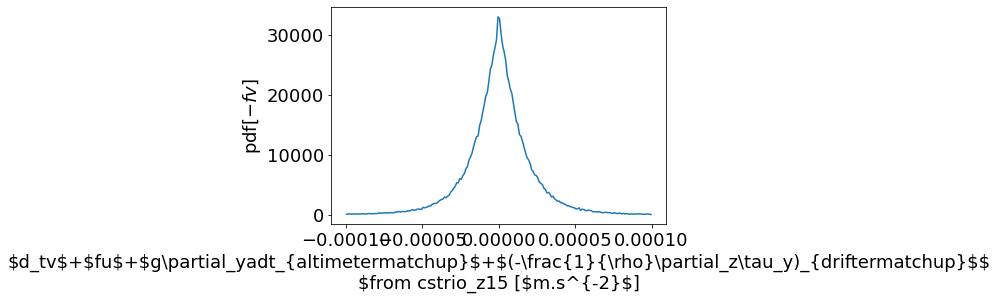

In [11]:
ds_pdf_all.pdf_drifter_coriolis_x.plot()

## Coriolis

0.999010997857576
0.999010997857576


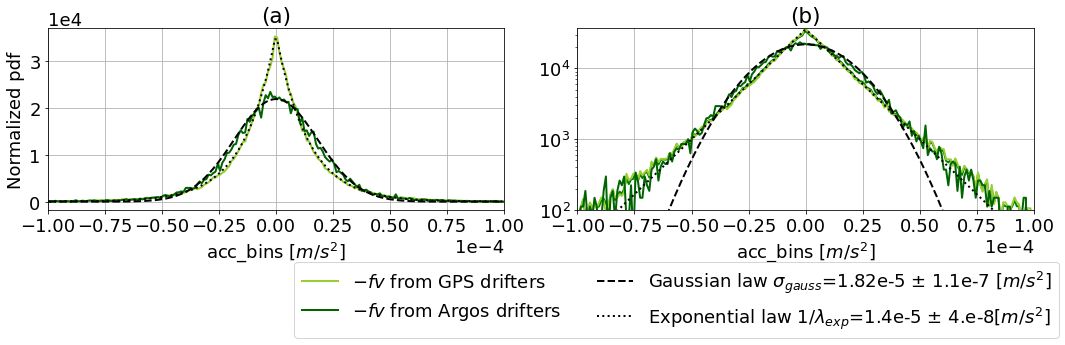

In [38]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
#mu=ds_all['mean_drifter_coriolis_x'].values
#mu=0
#sigg=ds_all['std_drifter_coriolis_x'].values
#sige=0.15e-4 #1/lamb
#sigg=0.18e-4 #1/lamb
#gaus = gaussian_pdf(ds_pdf_all.acc_bin.values, mu, sigg)
#exp = exp_pdf_sig(ds_pdf_all.acc_bin.values, sige)

#pdf acc
#ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green',label= lab['coriolis_x'].replace('drifters', 'all drifters'), ax=ax[0], lw=2)
ds_pdf_gps.pdf_drifter_coriolis_x.plot(color='yellowgreen',label= lab['coriolis_x'].replace('drifters', 'GPS drifters'),  ax=ax[0], lw=2)
ds_pdf_argos.pdf_drifter_coriolis_x.plot(color='darkgreen',label= lab['coriolis_x'].replace('drifters', 'Argos drifters'),  ax=ax[0], lw=2)
fit_gauss(ds_pdf_argos.pdf_drifter_coriolis_x, ax[0], color = 'k', ls='--', lw=2)
fit_exp(ds_pdf_gps.pdf_drifter_coriolis_x, ax[0], color = 'k', ls=':', lw=2)
#ax[0].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':', label = fr'Normal law $\sigma ={sigg}$')
#ax[0].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--', label = fr'Exponential law $\lambda ={round(1/sige)}$')

#log pdf acc
ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ax=ax[1], lw=2)
ds_pdf_gps.pdf_drifter_coriolis_x.plot(color='yellowgreen',  ax=ax[1], lw=2)
ds_pdf_argos.pdf_drifter_coriolis_x.plot(color='darkgreen',  ax=ax[1], lw=2)
fit_gauss(ds_pdf_argos.pdf_drifter_coriolis_x, ax[1], color = 'k', ls='--',  label=False, lw=2)
fit_exp(ds_pdf_gps.pdf_drifter_coriolis_x, ax[1], color = 'k', ls=':',  label=False, lw=2)

for a in ax:
    a.set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    a.ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    a.grid()
    
    #ax.set_ylim(0,9e4)
    a.set_xlim(-1e-4,1e-4)
ax[1].set_ylim(100)
ax[1].set_yscale('log')    


ax[0].set_ylabel('Normalized pdf')
ax[1].set_ylabel('')

ax[0].set_title(cstes.lettres[0])
ax[1].set_title(cstes.lettres[1])

fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=2,)
#fig.suptitle("PDFs of the acceleration and coriolis terms")
fig.tight_layout(rect=[0,0.18,1,1])#left, bottom, right, top (default is 0,0,1,1)

0.9985424406585295


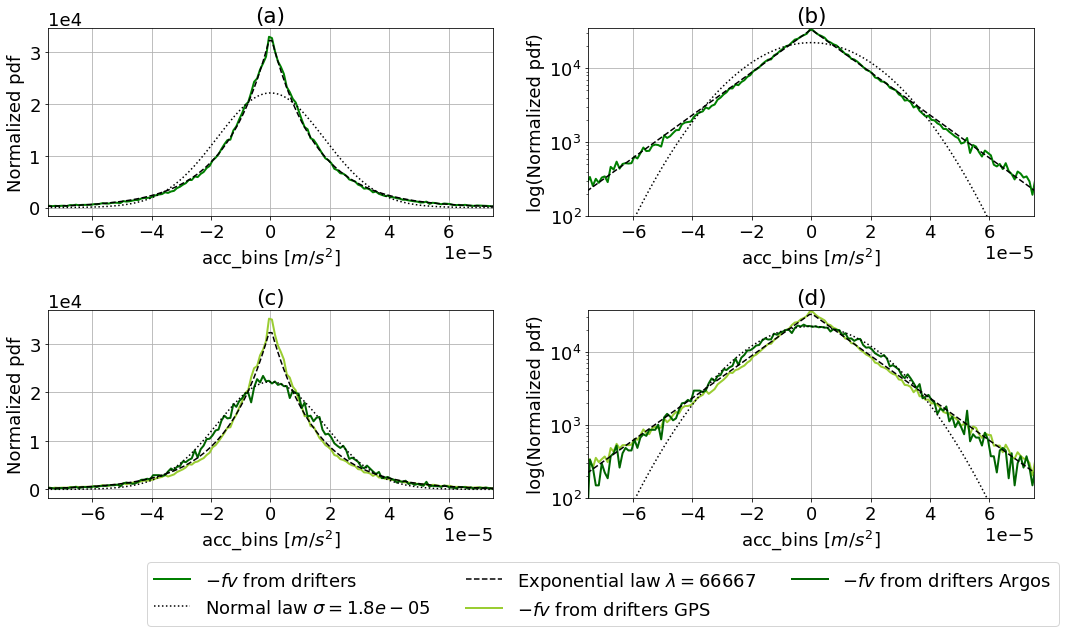

In [13]:
fig, ax = plt.subplots(2,2,figsize=(15,9))
#mu=ds_all['mean_drifter_coriolis_x'].values
mu=0
#sigg=ds_all['std_drifter_coriolis_x'].values
sige=0.15e-4 #1/lamb
sigg=0.18e-4 #1/lamb
gaus = gaussian_pdf(ds_pdf_all.acc_bin.values, mu, sigg)
exp = exp_pdf_sig(ds_pdf_all.acc_bin.values, sige)

ax = ax.flatten()

#pdf acc
#ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green',label= lab['coriolis_x'], ax=ax[0], lw=2)
#ds_pdf_gps.pdf_drifter_coriolis_x.plot(color='yellowgreen',label= lab['coriolis_x']+' from gps',  ax=ax[0])
#ds_pdf_argos.pdf_drifter_coriolis_x.plot(color='darkgreen',label= lab['coriolis_x']+' from argos',  ax=ax[0])
ax[0].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':', label = fr'Normal law $\sigma ={sigg}$')
ax[0].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--', label = fr'Exponential law $\lambda ={round(1/sige)}$')

#log pdf acc
ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ax=ax[1], lw=2)
#ds_pdf_gps.pdf_drifter_coriolis_x.plot(color='yellowgreen',  ax=ax[1])
#ds_pdf_argos.pdf_drifter_coriolis_x.plot(color='darkgreen',  ax=ax[1])
ax[1].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':')
ax[1].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--')

#pdf acc
#ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green',label= lab['coriolis_x'], ax=ax[0])
ds_pdf_gps.pdf_drifter_coriolis_x.plot(color='yellowgreen',label= lab['coriolis_x']+' GPS',  ax=ax[2], lw=2)
ds_pdf_argos.pdf_drifter_coriolis_x.plot(color='darkgreen',label= lab['coriolis_x']+' Argos',  ax=ax[2], lw=2)
ax[2].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':', )
ax[2].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--',)

#log pdf acc
#ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ax=ax[1])
ds_pdf_gps.pdf_drifter_coriolis_x.plot(color='yellowgreen',  ax=ax[3], lw=2)
ds_pdf_argos.pdf_drifter_coriolis_x.plot(color='darkgreen',  ax=ax[3], lw=2)
ax[3].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':')
ax[3].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--')

for i in range(len(ax)):
    ax[i].set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    ax[i].ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    ax[i].grid()
    #ax.set_ylim(0,9e4)
    ax[i].set_xlim(-0.75e-4,0.75e-4)
    ax[i].set_title(cstes.lettres[i])
ax[1].set_ylim(100)
ax[1].set_yscale('log')    
ax[3].set_ylim(100)
ax[3].set_yscale('log')

ax[0].set_ylabel('Normalized pdf')
ax[1].set_ylabel('log(Normalized pdf)')
ax[2].set_ylabel('Normalized pdf')
ax[3].set_ylabel('log(Normalized pdf)')

fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=3)
#fig.suptitle("PDFs of coriolis terms")
fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)

## acc

0.9991300293685008
0.9995288816584567
0.9991300293685008
0.9995288816584567


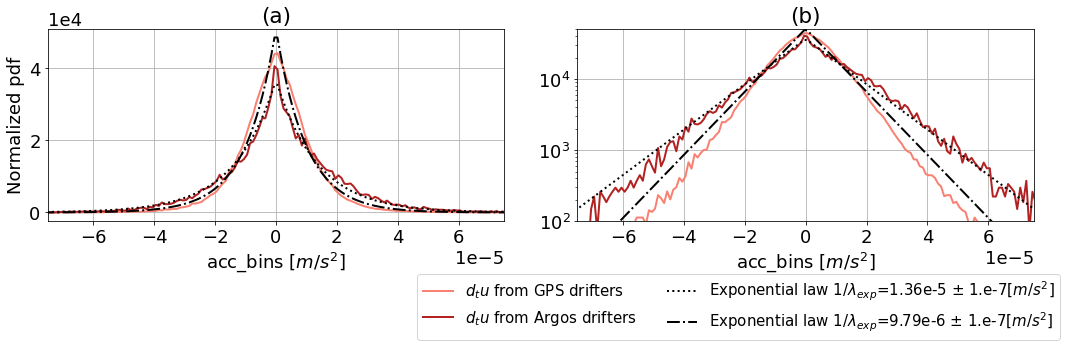

In [41]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax = ax.flatten()
#ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green',label= lab['coriolis_x'], ls=':', ax=ax[0])
#ds_pdf_all.pdf_drifter_acc_x.plot(color='red', label= lab['acc_x'], ax=ax[0])
ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon', label= lab['acc_x'].replace('drifters', 'GPS drifters'), ax=ax[0], lw=2)
ds_pdf_argos.pdf_drifter_acc_x.plot(color='firebrick', label= lab['acc_x'].replace('drifters', 'Argos drifters'), ax=ax[0], lw=2)
fit_exp(ds_pdf_argos.pdf_drifter_acc_x, ax[0], color = 'k', ls=':', lw=2)
fit_exp(ds_pdf_gps.pdf_drifter_acc_x, ax[0], color = 'k', ls='-.', lw=2)

#ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', ax=ax[1])
#ds_pdf_all.pdf_drifter_acc_x.plot(color='red',  ax=ax[1])
ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon',  ax=ax[1] , lw=2)
ds_pdf_argos.pdf_drifter_acc_x.plot(color='firebrick',  ax=ax[1], lw=2)
fit_exp(ds_pdf_argos.pdf_drifter_acc_x, ax[1], color = 'k', ls=':',label=False, lw=2)
fit_exp(ds_pdf_gps.pdf_drifter_acc_x, ax[1], color = 'k', ls='-.',  label=False, lw=2)

for i in range(len(ax)):
    ax[i].set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    ax[i].ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    ax[i].grid()
    #ax.set_ylim(0,9e4)
    ax[i].set_xlim(-0.75e-4,0.75e-4)
    ax[i].set_title(cstes.lettres[i])
ax[1].set_ylim(100)
ax[1].set_yscale('log')  

ax[0].set_ylabel('Normalized pdf')
ax[1].set_ylabel('')


fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=2, fontsize=15)
#fig.suptitle("PDFs of the acceleration terms")
fig.tight_layout(rect=[0,0.15,1,1])#left, bottom, right, top (default is 0,0,1,1)

0.9992972828060436


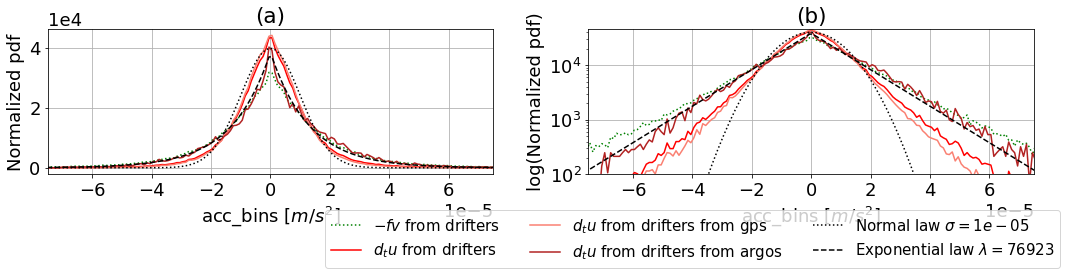

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

#mu=ds_all['mean_drifter_coriolis_x'].values
mu=0
#sigg=ds_all['std_drifter_coriolis_x'].values
sige=0.13e-4 #1/lamb
sigg=0.1e-4 #1/lamb
gaus = gaussian_pdf(ds_pdf_all.acc_bin.values, mu, sigg)
exp = exp_pdf_sig(ds_pdf_all.acc_bin.values, sige)

ax = ax.flatten()
ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green',label= lab['coriolis_x'], ls=':', ax=ax[0])
ds_pdf_all.pdf_drifter_acc_x.plot(color='red', label= lab['acc_x'], ax=ax[0])
ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon', label= lab['acc_x']+' from gps', ax=ax[0])
ds_pdf_argos.pdf_drifter_acc_x.plot(color='firebrick', label= lab['acc_x']+' from argos', ax=ax[0])
ax[0].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':', label = fr'Normal law $\sigma ={sigg}$')
ax[0].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--', label = fr'Exponential law $\lambda ={round(1/sige)}$')

ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', ax=ax[1])
ds_pdf_all.pdf_drifter_acc_x.plot(color='red',  ax=ax[1])
ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon',  ax=ax[1])
ds_pdf_argos.pdf_drifter_acc_x.plot(color='firebrick',  ax=ax[1])
ax[1].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':')
ax[1].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--')


for i in range(len(ax)):
    ax[i].set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    ax[i].ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    ax[i].grid()
    #ax.set_ylim(0,9e4)
    ax[i].set_xlim(-0.75e-4,0.75e-4)
    ax[i].set_title(cstes.lettres[i])
ax[1].set_ylim(100)
ax[1].set_yscale('log')  

ax[0].set_ylabel('Normalized pdf', )
ax[1].set_ylabel('log(Normalized pdf)',)


fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=3, fontsize=15)
#fig.suptitle("PDFs of the acceleration terms")
fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)

0.9992972828060436


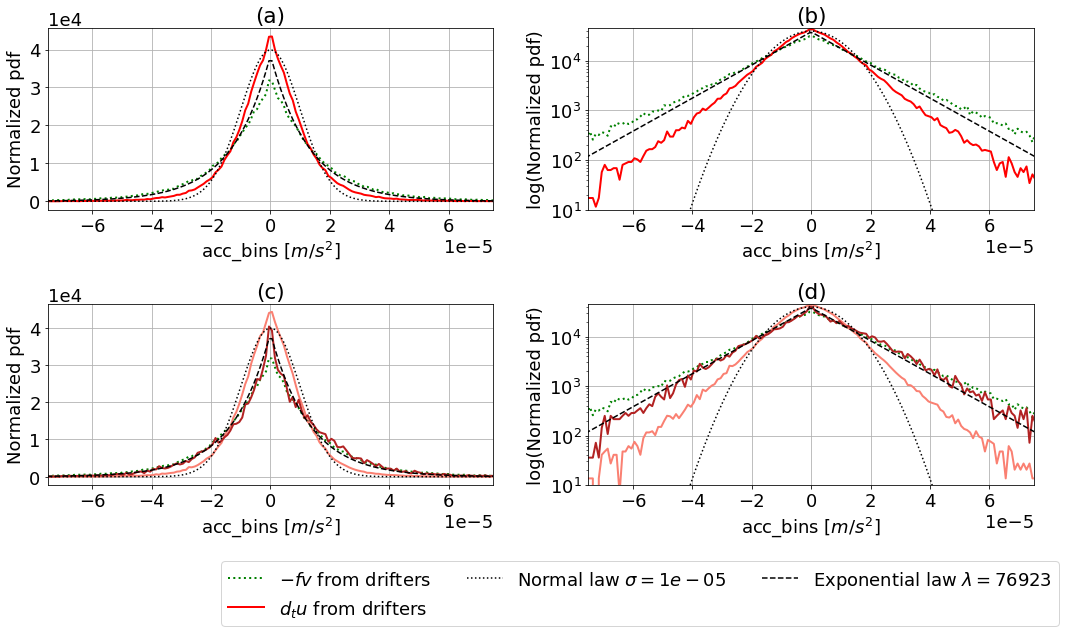

In [16]:
fig, ax = plt.subplots(2,2,figsize=(15,9))

#mu=ds_all['mean_drifter_coriolis_x'].values
mu=0
#sigg=ds_all['std_drifter_coriolis_x'].values
sige=0.13e-4 #1/lamb
sigg=0.1e-4 #1/lamb
gaus = gaussian_pdf(ds_pdf_all.acc_bin.values, mu, sigg)
exp = exp_pdf_sig(ds_pdf_all.acc_bin.values, sige)

ax = ax.flatten()
ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green',label= lab['coriolis_x'], ls=':', ax=ax[0], lw=2)
ds_pdf_all.pdf_drifter_acc_x.plot(color='red', label= lab['acc_x'], ax=ax[0], lw=2)
#ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon', label= lab['acc_x']+' from gps', ax=ax[0])
#ds_pdf_argos.pdf_drifter_acc_x.plot(color='firebrick', label= lab['acc_x']+' from argos', ax=ax[0])
ax[0].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':', label = fr'Normal law $\sigma ={sigg}$')
ax[0].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--', label = fr'Exponential law $\lambda ={round(1/sige)}$')

ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', ax=ax[1], lw=2)
ds_pdf_all.pdf_drifter_acc_x.plot(color='red',  ax=ax[1], lw=2)
#ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon',  ax=ax[1])
#ds_pdf_argos.pdf_drifter_acc_x.plot(color='firebrick',  ax=ax[1])
ax[1].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':')
ax[1].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--')

ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', ax=ax[2], lw=2)
#ds_pdf_all.pdf_drifter_acc_x.plot(color='red', label= lab['acc_x'], ax=ax[0])
ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon',  ax=ax[2], lw=2)
ds_pdf_argos.pdf_drifter_acc_x.plot(color='firebrick',  ax=ax[2], lw=2)
ax[2].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':',)
ax[2].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--', )

ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', ax=ax[3], lw=2)
#ds_pdf_all.pdf_drifter_acc_x.plot(color='red',  ax=ax[1])
ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon',  ax=ax[3], lw=2)
ds_pdf_argos.pdf_drifter_acc_x.plot(color='firebrick',  ax=ax[3], lw=2)
ax[3].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':')
ax[3].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--')

for i in range(len(ax)):
    ax[i].set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    ax[i].ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    ax[i].grid()
    #ax.set_ylim(0,9e4)
    ax[i].set_xlim(-0.75e-4,0.75e-4)
    ax[i].set_title(cstes.lettres[i])
ax[1].set_ylim(10)
ax[1].set_yscale('log')  
ax[3].set_ylim(10)
ax[3].set_yscale('log') 


ax[0].set_ylabel('Normalized pdf')
ax[1].set_ylabel('log(Normalized pdf)')
ax[2].set_ylabel('Normalized pdf')
ax[3].set_ylabel('log(Normalized pdf)')

fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=3)
#fig.suptitle("PDFs of the acceleration terms")
fig.tight_layout(rect=[0,0.12,1,1])#left, bottom, right, top (default is 0,0,1,1)

##  grad sla

0.9994704068054161
0.9987624357421983


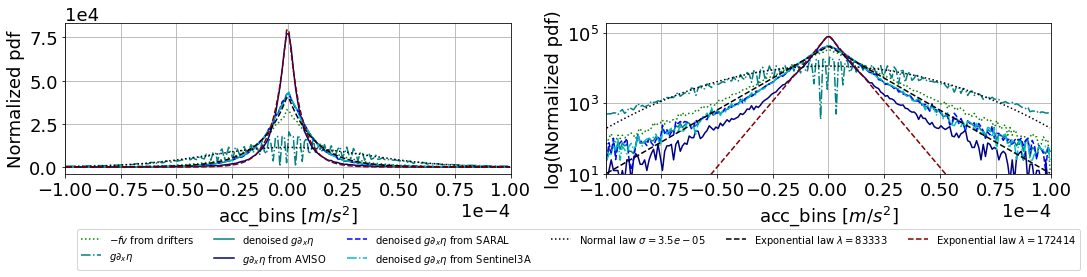

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,4))
#mu=ds_all['mean_drifter_coriolis_x'].values
mu=0
#sigg=ds_all['std_drifter_coriolis_x'].values
sige=0.12e-4 #1/lamb
sigg=0.35e-4 #1/lamb
sige2 = 5.8e-6 #1/lamb
gaus = gaussian_pdf(ds_pdf_all.acc_bin.values, mu, sigg)
exp = exp_pdf_sig(ds_pdf_all.acc_bin.values, sige)
exp2 = exp_pdf_sig(ds_pdf_all.acc_bin.values, sige2)

ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', label= lab['coriolis_x'], ax=ax[0])
ds_pdf_all.pdf_alti_g_grad_x.plot(color='teal',  label= lab['alti_g_grad_x'],ls='-.', ax=ax[0])
ds_pdf_all.pdf_alti_denoised_g_grad_x.plot(color='teal',  label= lab['alti_denoised_g_grad_x'], ax=ax[0])
ds_pdf_all.pdf_aviso_alti_g_grad_x.plot(color='navy', label= lab['aviso_alti_matchup_g_grad_x'], ax=ax[0])
ds_pdf_saral.pdf_alti_denoised_g_grad_x.plot(color='b',  label= lab['alti_denoised_g_grad_x']+ ' from SARAL', ls='--', ax=ax[0])
ds_pdf_sentinel.pdf_alti_denoised_g_grad_x.plot(color='c',  label= lab['alti_denoised_g_grad_x']+ ' from Sentinel3A', ls='-.', ax=ax[0])
ax[0].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':', label = fr'Normal law $\sigma ={sigg}$')
ax[0].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--', label = fr'Exponential law $\lambda ={round(1/sige)}$')
ax[0].plot(ds_pdf_all.acc_bin.values, exp2[0], color = 'maroon', ls='--', label = fr'Exponential law $\lambda ={round(1/sige2)}$')

ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', ax=ax[1])
ds_pdf_all.pdf_alti_g_grad_x.plot(color='teal',ls='-.', ax=ax[1])
ds_pdf_all.pdf_alti_denoised_g_grad_x.plot(color='teal', ax=ax[1])
ds_pdf_all.pdf_aviso_alti_g_grad_x.plot(color='navy', ax=ax[1])
ds_pdf_saral.pdf_alti_denoised_g_grad_x.plot(color='b', ls='--', ax=ax[1])
ds_pdf_sentinel.pdf_alti_denoised_g_grad_x.plot(color='c', ls='-.', ax=ax[1])
ax[1].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':',)
ax[1].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'k', ls='--',)
ax[1].plot(ds_pdf_all.acc_bin.values, exp2[0], color = 'maroon', ls='--',)

for a in ax:
    a.set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    a.ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    a.grid()
    #ax.set_ylim(0,9e4)
    a.set_xlim(-1e-4,1e-4)
ax[1].set_yscale('log')    
ax[1].set_ylim(10)
ax[0].set_ylabel('Normalized pdf')
ax[1].set_ylabel('log(Normalized pdf)')

fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=6, fontsize=10)
#fig.suptitle(r"PDFs of $g\partial_x\eta$")
fig.tight_layout(rect=[0,0.1,1,1])#left, bottom, right, top (default is 0,0,1,1)

0.9995289744426445
0.9987668502024554
0.9995289744426445
0.9987668502024554
0.9995289744426445
0.9995289744426445


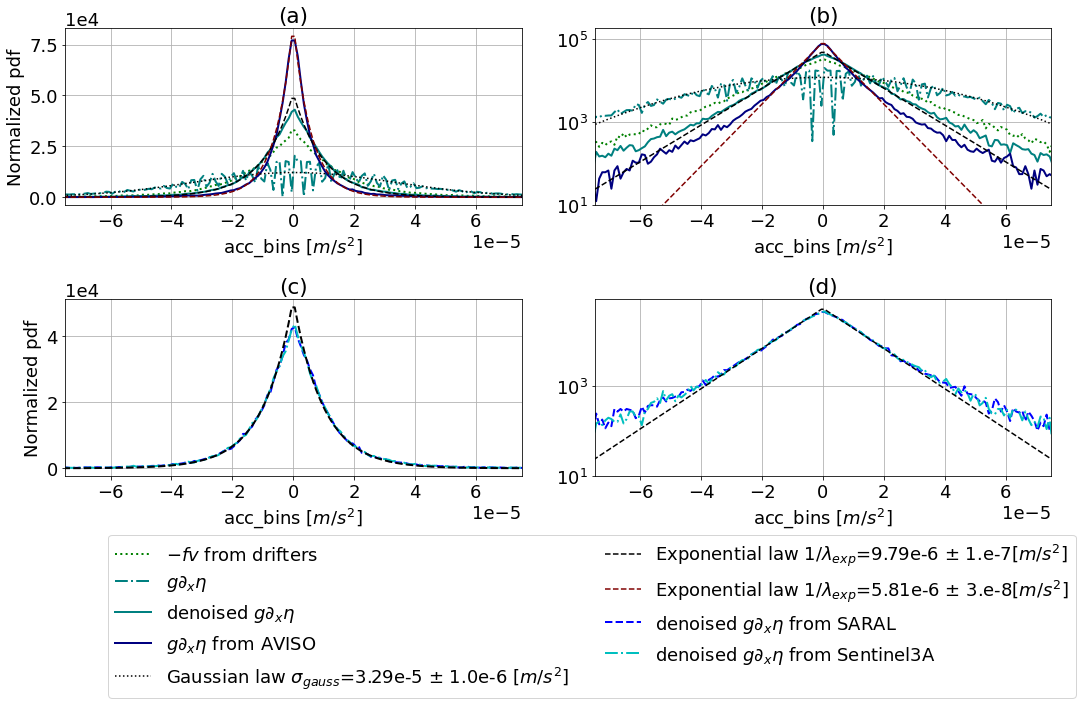

In [16]:
fig, ax = plt.subplots(2,2,figsize=(15,10))

ax = ax.flatten()

#
ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', label= lab['coriolis_x'], ax=ax[0], lw=2)
ds_pdf_all.pdf_alti_g_grad_x.plot(color='teal',  label= lab['alti_g_grad_x'],ls='-.', ax=ax[0], lw=2)
ds_pdf_all.pdf_alti_denoised_g_grad_x.plot(color='teal',  label= lab['alti_denoised_g_grad_x'], ax=ax[0], lw=2)
ds_pdf_all.pdf_aviso_alti_g_grad_x.plot(color='navy', label= lab['aviso_alti_matchup_g_grad_x'], ax=ax[0], lw=2)

fit_gauss(ds_pdf_all.pdf_alti_g_grad_x, ax[0], color = 'k', ls=':')
fit_exp(ds_pdf_gps.pdf_drifter_acc_x, ax[0], color = 'k', ls='--')
fit_exp(ds_pdf_all.pdf_aviso_alti_g_grad_x, ax[0], color = 'maroon', ls='--')

#log
ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', ax=ax[1], lw=2)
ds_pdf_all.pdf_alti_g_grad_x.plot(color='teal',ls='-.', ax=ax[1], lw=2)
ds_pdf_all.pdf_alti_denoised_g_grad_x.plot(color='teal', ax=ax[1], lw=2)
ds_pdf_all.pdf_aviso_alti_g_grad_x.plot(color='navy', ax=ax[1], lw=2)

fit_gauss(ds_pdf_all.pdf_alti_g_grad_x, ax[1], color = 'k', ls=':',  label=False)
fit_exp(ds_pdf_gps.pdf_drifter_acc_x, ax[1], color = 'k', ls='--', label=False)
fit_exp(ds_pdf_all.pdf_aviso_alti_g_grad_x, ax[1], color = 'maroon', ls='--', label=False)

#ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green',ls=':',  ax=ax[2], lw=2)
ds_pdf_saral.pdf_alti_denoised_g_grad_x.plot(color='b',ls='--',label= lab['alti_denoised_g_grad_x']+ ' from SARAL', ax=ax[2], lw=2)
ds_pdf_sentinel.pdf_alti_denoised_g_grad_x.plot(color='c', ls='-.', label= lab['alti_denoised_g_grad_x']+ ' from Sentinel3A', ax=ax[2], lw=2)
#ds_pdf_all.pdf_aviso_alti_g_grad_x.plot(color='navy', ax=ax[2])
fit_exp(ds_pdf_gps.pdf_drifter_acc_x, ax[2], color = 'k', ls='--', lw=2, label=False)

#ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', ax=ax[3], lw=2)
ds_pdf_saral.pdf_alti_denoised_g_grad_x.plot(color='b', ls='--', ax=ax[3], lw=2)
ds_pdf_sentinel.pdf_alti_denoised_g_grad_x.plot(color='c', ls='-.', ax=ax[3], lw=2)
#ds_pdf_all.pdf_aviso_alti_g_grad_x.plot(color='navy', ax=ax[3])
#ax[1].plot(ds_pdf_all.acc_bin.values, gaus, color = 'k', ls=':',)
fit_exp(ds_pdf_gps.pdf_drifter_acc_x, ax[3], color = 'k', ls='--', label=False)



for i in range(len(ax)):
    ax[i].set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    ax[i].ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    ax[i].grid()
    #ax.set_ylim(0,9e4)
    ax[i].set_xlim(-0.75e-4,0.75e-4)
    ax[i].set_title(cstes.lettres[i])
    
ax[1].set_yscale('log')    
ax[1].set_ylim(10)
ax[3].set_yscale('log')    
ax[3].set_ylim(10)
ax[0].set_ylabel('Normalized pdf')
ax[1].set_ylabel('')
ax[2].set_ylabel('Normalized pdf')
ax[3].set_ylabel('')
fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=2)
#fig.suptitle(r"PDFs of $g\partial_x\eta$")
fig.tight_layout(rect=[0,0.22,1,1])#left, bottom, right, top (default is 0,0,1,1)

0.9995482687482424
0.9987668450840458
0.9995482687482424
0.9987668450840458


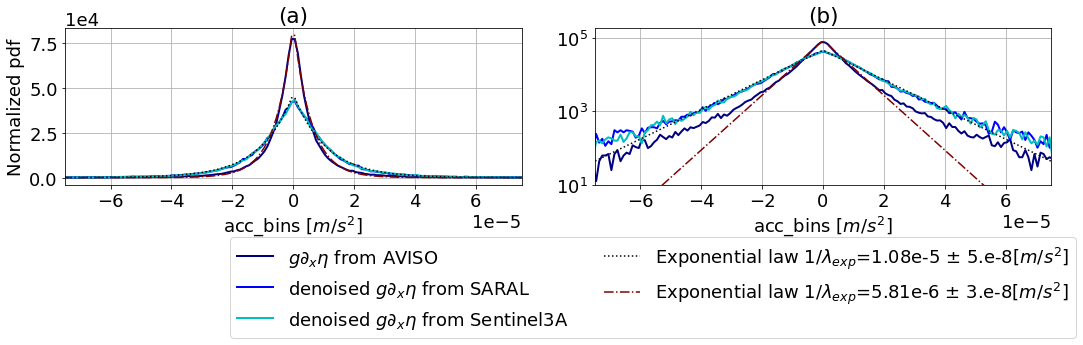

In [35]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

ax = ax.flatten()

#
#ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', label= lab['coriolis_x'], ax=ax[0], lw=2)
#ds_pdf_all.pdf_alti_g_grad_x.plot(color='teal',  label= lab['alti_g_grad_x'],ls='-.', ax=ax[0], lw=2)
#ds_pdf_all.pdf_alti_denoised_g_grad_x.plot(color='teal',  label= lab['alti_denoised_g_grad_x'], ax=ax[0], lw=2)
ds_pdf_all.pdf_aviso_alti_g_grad_x.plot(color='navy', label= lab['aviso_alti_matchup_g_grad_x'], ax=ax[0], lw=2)
ds_pdf_saral.pdf_alti_denoised_g_grad_x.plot(color='b',label= lab['alti_denoised_g_grad_x']+ ' from SARAL', ax=ax[0], lw=2)
ds_pdf_sentinel.pdf_alti_denoised_g_grad_x.plot(color='c', label= lab['alti_denoised_g_grad_x']+ ' from Sentinel3A', ax=ax[0], lw=2)

#fit_gauss(ds_pdf_all.pdf_alti_g_grad_x, ax[0], color = 'k', ls='--')
fit_exp(ds_pdf_saral.pdf_alti_denoised_g_grad_x, ax[0], color = 'k', ls=':')
fit_exp(ds_pdf_all.pdf_aviso_alti_g_grad_x, ax[0], color = 'maroon', ls='-.')

#log
ds_pdf_all.pdf_aviso_alti_g_grad_x.plot(color='navy', ax=ax[1], lw=2)
ds_pdf_saral.pdf_alti_denoised_g_grad_x.plot(color='b', ax=ax[1], lw=2)
ds_pdf_sentinel.pdf_alti_denoised_g_grad_x.plot(color='c',  ax=ax[1], lw=2)

#fit_gauss(ds_pdf_all.pdf_alti_g_grad_x, ax[0], color = 'k', ls='--')
fit_exp(ds_pdf_saral.pdf_alti_denoised_g_grad_x, ax[1], color = 'k', ls=':', label=False)
fit_exp(ds_pdf_all.pdf_aviso_alti_g_grad_x, ax[1], color = 'maroon', ls='-.', label=False)

for i in range(len(ax)):
    ax[i].set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    ax[i].ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    ax[i].grid()
    #ax.set_ylim(0,9e4)
    ax[i].set_xlim(-0.75e-4,0.75e-4)
    ax[i].set_title(cstes.lettres[i])
    
ax[1].set_yscale('log')    
ax[1].set_ylim(10)

ax[0].set_ylabel('Normalized pdf')
ax[1].set_ylabel('')

fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=2)
#fig.suptitle(r"PDFs of $g\partial_x\eta$")
fig.tight_layout(rect=[0,0.25,1,1])#left, bottom, right, top (default is 0,0,1,1)

## corrected grad

0.99948580422548
0.9990429064328336
0.99948580422548
0.9990429064328336


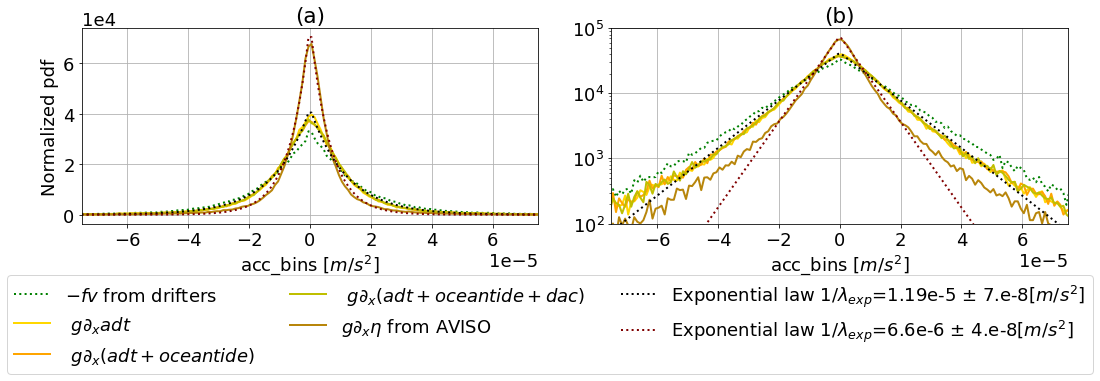

In [43]:
fig, ax = plt.subplots(1,2,figsize=(15,5.5))

ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', label= lab['coriolis_x'], ax=ax[0], lw=2)
#ds_pdf_all.pdf_alti_denoised_g_grad_x.plot(color='c',  label= lab['alti_denoised_g_grad_x'], ax=ax[0])
ds_pdf_all.pdf_alti_adt_g_grad_x.plot(color='gold',  label= lab['alti_adt_g_grad_x'], ax=ax[0], lw=2)
ds_pdf_all.pdf_alti_adt_oceantide_g_grad_x.plot(color='orange',  label= lab['alti_adt_oceantide_g_grad_x'], ax=ax[0], lw=2)
ds_pdf_all.pdf_alti_adt_oceantide_dac_g_grad_x.plot(color='y',  label= lab['alti_adt_oceantide_dac_g_grad_x'], ax=ax[0], lw=2)
ds_pdf_all.pdf_aviso_alti_adt_g_grad_x.plot(color='darkgoldenrod', label= lab['aviso_alti_matchup_g_grad_x'], ax=ax[0], lw=2)

fit_exp(ds_pdf_all.pdf_alti_adt_oceantide_dac_g_grad_x, ax[0], color = 'k', ls=':', lw=2)
fit_exp(ds_pdf_all.pdf_aviso_alti_adt_g_grad_x, ax[0], color = 'maroon', ls=':', lw=2)

ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':', ax=ax[1], lw=2)
#ds_pdf_all.pdf_alti_denoised_g_grad_x.plot(color='c',  label= lab['alti_denoised_g_grad_x'], ax=ax[1])
ds_pdf_all.pdf_alti_adt_g_grad_x.plot(color='gold',  ax=ax[1], lw=2)
ds_pdf_all.pdf_alti_adt_oceantide_g_grad_x.plot(color='orange',  ax=ax[1], lw=2)
ds_pdf_all.pdf_alti_adt_oceantide_dac_g_grad_x.plot(color='y',  ax=ax[1], lw=2)
ds_pdf_all.pdf_aviso_alti_adt_g_grad_x.plot(color='darkgoldenrod', ax=ax[1], lw=2)

fit_exp(ds_pdf_all.pdf_alti_adt_oceantide_dac_g_grad_x, ax[1], color = 'k', ls=':', label=False, lw=2)
fit_exp(ds_pdf_all.pdf_aviso_alti_adt_g_grad_x, ax[1], color = 'maroon', ls=':', label=False, lw=2)


for i in range(len(ax)):
    ax[i].set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    ax[i].ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    ax[i].grid()
    #ax.set_ylim(0,9e4)
    ax[i].set_xlim(-0.75e-4,0.75e-4)
    ax[i].set_title(cstes.lettres[i])
ax[1].set_yscale('log') 
ax[1].set_ylim(100, 1e5)

ax[0].set_ylabel('Normalized pdf')
ax[1].set_ylabel('')

fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=3)
#fig.suptitle(r"PDFs of $g\partial_xH$")
fig.tight_layout(rect=[0,0.22,1,1])#left, bottom, right, top (default is 0,0,1,1)

## Wind

0.9935216298599696
0.9682003995772037
0.9682003995772037
0.9935216298599696


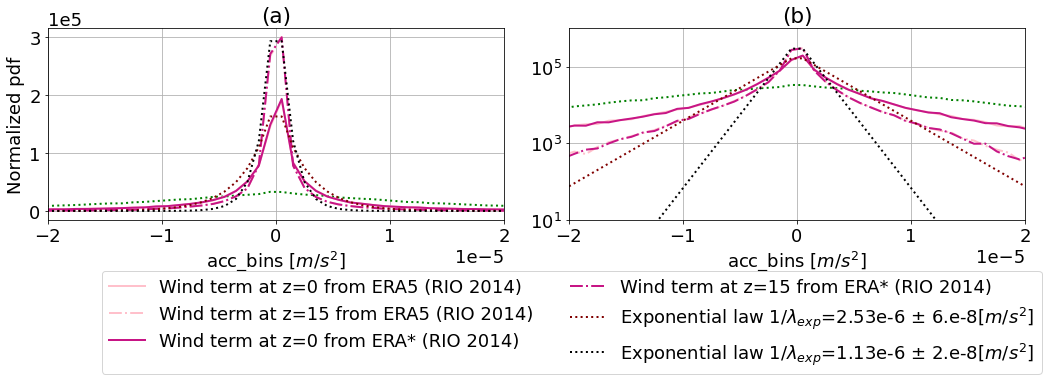

In [47]:
fig, ax = plt.subplots(1,2,figsize=(15,5.5))

ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':',  ax=ax[0], lw=2)
ds_pdf_all.pdf_e5_cstrio_z0_drifter_wd_x.plot(color='pink', label= lab['e5_cstrio_z0_drifter_wd_x'], ax=ax[0], lw=2)
ds_pdf_all.pdf_e5_cstrio_z15_drifter_wd_x.plot(color='pink',ls='-.', label= lab['e5_cstrio_z15_drifter_wd_x'], ax=ax[0], lw=2)
ds_pdf_all.pdf_es_cstrio_z0_drifter_wd_x.plot(color='mediumvioletred', label= lab['es_cstrio_z0_drifter_wd_x'], ax=ax[0], lw=2)
ds_pdf_all.pdf_es_cstrio_z15_drifter_wd_x.plot(color='mediumvioletred',ls='-.', label= lab['es_cstrio_z15_drifter_wd_x'], ax=ax[0], lw=2)

#fit_exp(ds_pdf_all.pdf_alti_adt_oceantide_dac_g_grad_x, ax[0], color = 'k', ls='--')
fit_exp(ds_pdf_all.pdf_es_cstrio_z0_drifter_wd_x, ax[0], color = 'maroon', ls=':', lw=2)
fit_exp(ds_pdf_all.pdf_es_cstrio_z15_drifter_wd_x, ax[0], color = 'k', ls=':', lw=2)

ds_pdf_all.pdf_drifter_coriolis_x.plot(color='green', ls=':',  ax=ax[1], lw=2)
ds_pdf_all.pdf_e5_cstrio_z0_drifter_wd_x.plot(color='pink', ax=ax[1], lw=2)
ds_pdf_all.pdf_e5_cstrio_z15_drifter_wd_x.plot(color='pink',ls='-.',  ax=ax[1], lw=2)
ds_pdf_all.pdf_es_cstrio_z0_drifter_wd_x.plot(color='mediumvioletred',  ax=ax[1], lw=2)
ds_pdf_all.pdf_es_cstrio_z15_drifter_wd_x.plot(color='mediumvioletred',ls='-.', ax=ax[1], lw=2)
fit_exp(ds_pdf_all.pdf_es_cstrio_z15_drifter_wd_x, ax[1], color = 'k', ls=':', label=False, lw=2)
fit_exp(ds_pdf_all.pdf_es_cstrio_z0_drifter_wd_x, ax[1], color = 'maroon', ls=':', label=False, lw=2)
for i in range(len(ax)):
    ax[i].set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    ax[i].ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    ax[i].grid()
    #ax.set_ylim(0,9e4)
    ax[i].set_xlim(-0.2e-4,0.2e-4)
    ax[i].set_title(cstes.lettres[i])
ax[1].set_yscale('log') 
ax[1].set_ylim(10,1e6)

ax[0].set_ylabel('Normalized pdf')
ax[1].set_ylabel('')

fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=2,)
#fig.suptitle("PDFs of the vertical wind stress divergence")
fig.tight_layout(rect=[0,0.23,1,1])#left, bottom, right, top (default is 0,0,1,1)

0.9971441688415985
0.9971441688415985


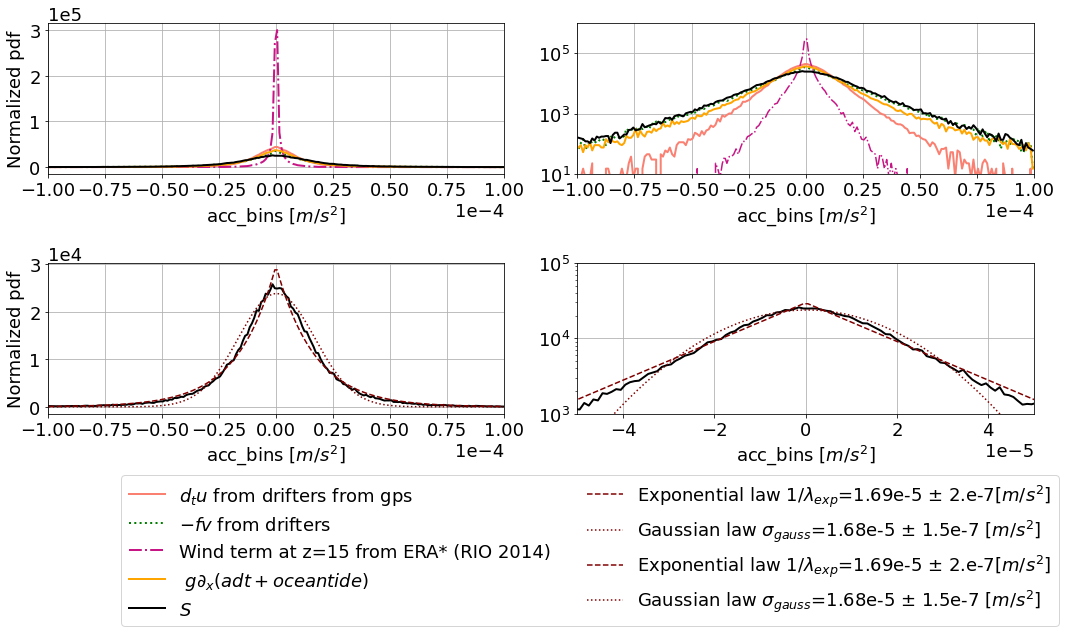

In [19]:
fig, ax = plt.subplots(2,2,figsize=(15,9))




ax = ax.flatten()
ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon', label= lab['acc_x']+' from gps', ax=ax[0], lw=2)
ds_pdf_gps.pdf_drifter_coriolis_x.plot(color='green', ls=':',label= lab['coriolis_x'],  ax=ax[0], lw=2)
ds_pdf_gps.pdf_es_cstrio_z15_drifter_wd_x.plot(color='mediumvioletred',ls='-.', label= lab['es_cstrio_z15_drifter_wd_x'], ax=ax[0], lw=2)
ds_pdf_gps.pdf_alti_adt_oceantide_g_grad_x.plot(color='orange',  label= lab['alti_adt_oceantide_g_grad_x'], ax=ax[0], lw=2)
#ds_pdf_gps.pdf_aviso_alti_adt_g_grad_x.plot(color='darkgoldenrod', label= lab['aviso_alti_matchup_g_grad_x'], ax=ax[0])
ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x.plot(color='k',label=r'$S$', ax=ax[0], lw=2)


ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon',  ax=ax[1], lw=2)
ds_pdf_gps.pdf_drifter_coriolis_x.plot(color='green', ls=':',  ax=ax[1], lw=2)
ds_pdf_gps.pdf_es_cstrio_z15_drifter_wd_x.plot(color='mediumvioletred',ls='-.',  ax=ax[1])
ds_pdf_gps.pdf_alti_adt_oceantide_g_grad_x.plot(color='orange',  ax=ax[1], lw=2)
#ds_pdf_gps.pdf_aviso_alti_adt_g_grad_x.plot(color='darkgoldenrod',  ax=ax[1])
ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x.plot(color='k',  ax=ax[1], lw=2)
#ax[1].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'maroon', ls='--',)
#ax[1].plot(ds_pdf_all.acc_bin.values, gaus, color = 'maroon', ls=':',)

ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x.plot(color='k', ax=ax[2], lw=2)
fit_exp(ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x, ax[2], color = 'maroon', ls='--')
fit_gauss(ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x, ax[2], color = 'maroon', ls=':')

ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x.plot(color='k', ax=ax[3], lw=2)
fit_exp(ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x, ax[3], color = 'maroon', ls='--')
fit_gauss(ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x, ax[3], color = 'maroon', ls=':')


for a in ax:
    a.set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    a.ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    a.grid()
    #ax.set_ylim(0,9e4)
    a.set_xlim(-1e-4,1e-4)
ax[1].set_yscale('log') 
ax[1].set_ylim(10,1e6)
ax[3].set_yscale('log') 
ax[3].set_ylim(1000,1e5)
ax[3].set_xlim(-0.5e-4,0.5e-4)
ax[0].set_ylabel('Normalized pdf')
ax[1].set_ylabel('')
ax[2].set_ylabel('Normalized pdf')
ax[3].set_ylabel('')

fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=2)
#fig.suptitle("PDFs of all terms for gps drifters, erastar and adt+oceantide gradient ")
fig.tight_layout(rect=[0,0.23,1,1])#left, bottom, right, top (default is 0,0,1,1)

0.9966032855163164
0.9966032855163164


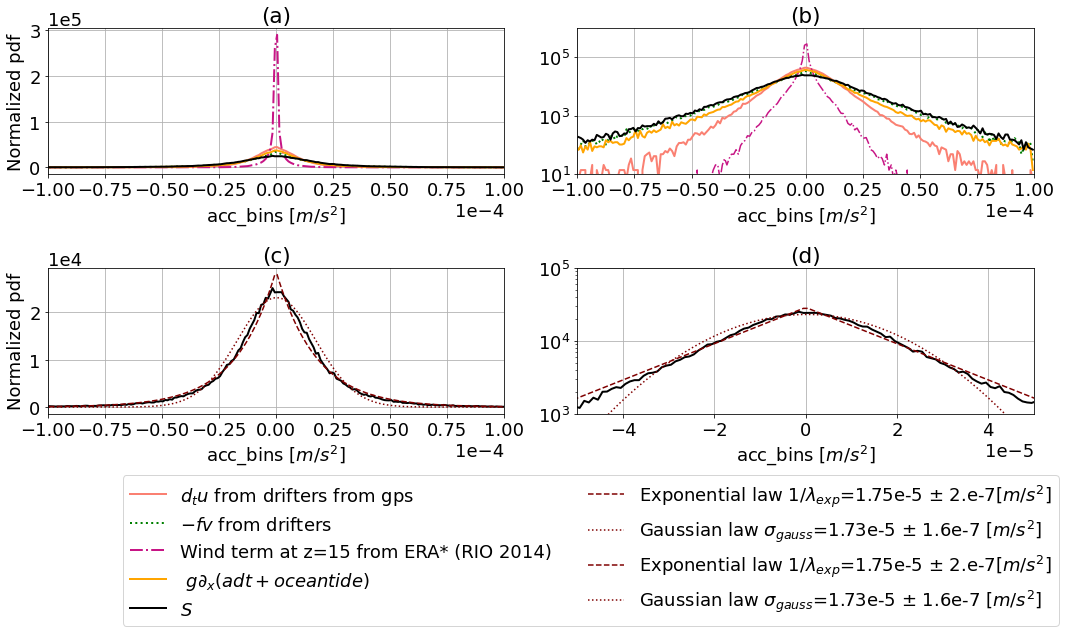

In [21]:
fig, ax = plt.subplots(2,2,figsize=(15,9))




ax = ax.flatten()
ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon', label= lab['acc_x']+' from gps', ax=ax[0], lw=2)
ds_pdf_gps.pdf_drifter_coriolis_x.plot(color='green', ls=':',label= lab['coriolis_x'],  ax=ax[0], lw=2)
ds_pdf_gps.pdf_es_cstrio_z15_drifter_wd_x.plot(color='mediumvioletred',ls='-.', label= lab['es_cstrio_z15_drifter_wd_x'], ax=ax[0], lw=2)
ds_pdf_gps.pdf_alti_adt_oceantide_g_grad_x.plot(color='orange',  label= lab['alti_adt_oceantide_g_grad_x'], ax=ax[0], lw=2)
#ds_pdf_gps.pdf_aviso_alti_adt_g_grad_x.plot(color='darkgoldenrod', label= lab['aviso_alti_matchup_g_grad_x'], ax=ax[0])
ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x.plot(color='k',label=r'$S$', ax=ax[0], lw=2)


ds_pdf_gps.pdf_drifter_acc_x.plot(color='salmon',  ax=ax[1], lw=2)
ds_pdf_gps.pdf_drifter_coriolis_x.plot(color='green', ls=':',  ax=ax[1], lw=2)
ds_pdf_gps.pdf_es_cstrio_z15_drifter_wd_x.plot(color='mediumvioletred',ls='-.',  ax=ax[1])
ds_pdf_gps.pdf_alti_adt_oceantide_g_grad_x.plot(color='orange',  ax=ax[1], lw=2)
#ds_pdf_gps.pdf_aviso_alti_adt_g_grad_x.plot(color='darkgoldenrod',  ax=ax[1])
ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x.plot(color='k',  ax=ax[1], lw=2)
#ax[1].plot(ds_pdf_all.acc_bin.values, exp[0], color = 'maroon', ls='--',)
#ax[1].plot(ds_pdf_all.acc_bin.values, gaus, color = 'maroon', ls=':',)

ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x.plot(color='k', ax=ax[2], lw=2)
fit_exp(ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x, ax[2], color = 'maroon', ls='--')
fit_gauss(ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x, ax[2], color = 'maroon', ls=':')

ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x.plot(color='k', ax=ax[3], lw=2)
fit_exp(ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x, ax[3], color = 'maroon', ls='--')
fit_gauss(ds_pdf_gps.pdf_sum_co_adt_oceantide_es_cstrio_z15_alti_x, ax[3], color = 'maroon', ls=':')


for a in ax:
    a.set_xlabel(r'acc_bins [$m/s^2$]')
    #a.set_title(title)
    a.ticklabel_format(axis='both', style='sci', scilimits=(-3, 3), useOffset=False)
    a.grid()
    #ax.set_ylim(0,9e4)
    a.set_xlim(-1e-4,1e-4)
ax[1].set_yscale('log') 
ax[1].set_ylim(10,1e6)
ax[3].set_yscale('log') 
ax[3].set_ylim(1000,1e5)
ax[3].set_xlim(-0.5e-4,0.5e-4)
ax[0].set_ylabel('Normalized pdf')
ax[1].set_ylabel('')
ax[2].set_ylabel('Normalized pdf')
ax[3].set_ylabel('')
for i in range(len(ax)):
    ax[i].set_title(cstes.lettres[i])

fig.legend(bbox_to_anchor=(1,0), loc="lower right", bbox_transform=fig.transFigure, ncol=2)
#fig.suptitle("PDFs of all terms for gps drifters, erastar and adt+oceantide gradient ")
fig.tight_layout(rect=[0,0.23,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [20]:
cluster.close()